# PROGETTO

## Berlin Airbnb Data

Il dataset considerato contiene numerose informazioni riguardanti gli annunci realtivi agli appartamenti disponibili su Airbnb nella città di Berlino.
Un nuovo host vuole aggiungere un annuncio per il suo alloggio e vuole trovare un prezzo che sia in linea con quelli degli appartamenti con caratteristiche simili al suo.
L'obiettivo di questo progetto è quindi prevedere il prezzo giornaliero di un alloggio, in modo che si adatti alla fetta di mercato a cui appartiene.

Il dataset utilizzato è scaricabile dal seguente link:
https://www.kaggle.com/brittabettendorf/berlin-airbnb-data/download

Ho scelto di utilizzare il CSV *listing_sunmmary*, poichè contiene le informazioni che sono utili allo scopo. 

Per configurare l'ambiente affinchè il progetto sia funzionante, si faccia riferimento al file REQUIREMENTS

In [1]:
# Import librerie
import os
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Definizione delle costanti
BASEPATH = os.path.abspath('')
DATASET = 'listings_summary.csv'
PATH = os.path.join(BASEPATH,DATASET)
print (PATH)
RANDOM_SEED = 22
K_FOLDS = 5

C:\Users\origgfe1\02_Formazione\Corsi\Percorso Data Science\Progetto\Berlin AirB&B\listings_summary.csv


### Import Data

In [4]:
df = pd.read_csv(PATH, low_memory=False)
df.head()

id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20181107122246   2018-11-07   
1  2695  https://www.airbnb.com/rooms/2695  20181107122246   2018-11-07   
2  3176  https://www.airbnb.com/rooms/3176  20181107122246   2018-11-07   
3  3309  https://www.airbnb.com/rooms/3309  20181107122246   2018-11-07   
4  7071  https://www.airbnb.com/rooms/7071  20181107122246   2018-11-07   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   
1                Prenzlauer Berg close to Mauerpark   
2                   Fabulous Flat in great Location   
3                 BerlinSpot Schöneberg near KaDeWe   
4                  BrightRoom with sunny greenview!   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   
1                                                NaN   
2  This beautiful first floor apartment  is situa...   
3  First of all: I prefer short-notice bookings. ...   
4  Cozy and large room in the beautiful district ...   

                                               space  \
0  A+++ location! This „Einliegerwohnung“ is an e...   
1  In the summertime we are spending most of our ...   
2  1st floor (68m2) apartment on Kollwitzplatz/ P...   
3  Your room is really big and has 26 sqm, is ver...   
4  The BrightRoom is an approx. 20 sqm (215ft²), ...   

                                         description experiences_offered  \
0  Great location!  30 of 75 sq meters. This wood...                none   
1  In the summertime we are spending most of our ...                none   
2  This beautiful first floor apartment  is situa...                none   
3  First of all: I prefer short-notice bookings. ...                none   
4  Cozy and large room in the beautiful district ...                none   

                               neighborhood_overview  ... requires_license  \
0  It is located in the former East Berlin area o...  ...                t   
1                                                NaN  ...                t   
2  The neighbourhood is famous for its variety of...  ...                t   
3  My flat is in the middle of West-Berlin, direc...  ...                t   
4  Great neighborhood with plenty of Cafés, Baker...  ...                t   

  license jurisdiction_names instant_bookable is_business_travel_ready  \
0     NaN                NaN                f                        f   
1     NaN                NaN                f                        f   
2     NaN                NaN                t                        f   
3     NaN                NaN                f                        f   
4     NaN                NaN                f                        f   

           cancellation_policy  require_guest_profile_picture  \
0  strict_14_with_grace_period                              f   
1                     flexible                              f   
2  strict_14_with_grace_period                              f   
3  strict_14_with_grace_period                              f   
4                     moderate                              f   

  require_guest_phone_verification  calculated_host_listings_count  \
0                                f                               4   
1                                f                               1   
2                                f                               1   
3                                f                               1   
4                                f                               1   

   reviews_per_month  
0               3.76  
1               1.42  
2               1.25  
3               0.39  
4               1.75  

[5 rows x 96 columns]

In [5]:
print(f'Il dataset ha {df.shape[0]} righe e {df.shape[1]} colonne.')
print(f'Contiene {df.duplicated().sum()} duplicati.')

Il dataset ha 22552 righe e 96 colonne.
Contiene 0 duplicati.


In [6]:
df.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 96, dtype: object

In [7]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Il numero di colonne è molto ampio, è possibile ridurlo in modo da concentrarsi solo su ciò che è utile al nostro scopo.
Visto che abbiamo ipotizzato di basarci solo sulle caratteristiche dell'alloggio, possiamo tralasciarle le informazioni riguardanti l'host e le review.

In [8]:
cols=['id', 'experiences_offered', 'neighbourhood_cleansed','neighbourhood_group_cleansed', 'latitude', 'longitude',
      'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
      'square_feet', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
      'maximum_nights', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

In [9]:
df_cols = df[cols]

In [10]:
print(f'La colonna id ha {df_cols.id.duplicated().sum()} duplicati.')

La colonna id ha 0 duplicati.


 La colonna id è utilizzabile come indice della tabella.

In [64]:
df_cols.set_index('id')

neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
id                                                                           
2015               Brunnenstr. Süd                        Mitte  52.534537   
2695      Prenzlauer Berg Nordwest                       Pankow  52.548513   
3176       Prenzlauer Berg Südwest                       Pankow  52.534996   
3309               Schöneberg-Nord       Tempelhof - Schöneberg  52.498855   
7071                Helmholtzplatz                       Pankow  52.543157   
...                            ...                          ...        ...   
29856708           Brunnenstr. Süd                        Mitte  52.533865   
29857108           Schöneberg-Nord       Tempelhof - Schöneberg  52.496211   
29864272   Prenzlauer Berg Südwest                       Pankow  52.531800   
29866805            Alexanderplatz                        Mitte  52.520802   
29867352         Schillerpromenade                     Neukölln  52.473762   

          longitude   property_type        room_type  accommodates  bathrooms  \
id                                                                              
2015      13.402557      Guesthouse  Entire home/apt             3        1.0   
2695      13.404553       Apartment     Private room             2        1.0   
3176      13.417579       Apartment  Entire home/apt             4        1.0   
3309      13.349065       Apartment     Private room             2        1.0   
7071      13.415091       Apartment     Private room             2        1.0   
...             ...             ...              ...           ...        ...   
29856708  13.400731       Apartment  Entire home/apt             2        1.0   
29857108  13.341738       Apartment      Shared room             6        1.0   
29864272  13.411999            Loft  Entire home/apt             2        1.0   
29866805  13.378688  Boutique hotel     Private room             2        1.0   
29867352  13.424447       Apartment     Private room             2        1.0   

          bedrooms  beds  ...  \
id                        ...   
2015           1.0   2.0  ...   
2695           1.0   1.0  ...   
3176           1.0   2.0  ...   
3309           1.0   1.0  ...   
7071           1.0   2.0  ...   
...            ...   ...  ...   
29856708       1.0   1.0  ...   
29857108       1.0   4.0  ...   
29864272       0.0   1.0  ...   
29866805       1.0   1.0  ...   
29867352       1.0   1.0  ...   

                                                  amenities price  \
id                                                                  
2015      {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...  60.0   
2695      {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...  17.0   
3176      {Internet,Wifi,Kitchen,"Buzzer/wireless interc...  90.0   
3309      {Internet,Wifi,"Pets allowed","Pets live on th...  26.0   
7071      {Wifi,Heating,"Family/kid friendly",Essentials...  42.0   
...                                                     ...   ...   
29856708  {Wifi,"Smoking allowed",Heating,Essentials,Sha...  60.0   
29857108  {TV,Wifi,Kitchen,"Free parking on premises","F...  20.0   
29864272  {Wifi,Kitchen,Heating,Washer,"Fire extinguishe...  85.0   
29866805  {Wifi,"Paid parking off premises",Doorman,Elev...  99.0   
29867352  {Wifi,"Air conditioning",Kitchen,Breakfast,Hea...  45.0   

          security_deposit  cleaning_fee  guests_included  extra_people  \
id                                                                        
2015                 200.0          30.0                1          28.0   
2695                   0.0           0.0                1           0.0   
3176                 200.0          50.0                2          20.0   
3309                 250.0          30.0                1          18.0   
7071                   0.0           0.0                1          24.0   
...                    ...           ...              ...           ...   
29856708       

In [54]:
print(f'Il dataset ridotto ha {df_cols.shape[0]} righe e {df_cols.shape[1]} colonne.')

Il dataset ridotto ha 22550 righe e 22 colonne.


### Pulizia del dato

In [55]:
df_cols.isnull().sum()

id                              0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
price                           0
security_deposit                0
cleaning_fee                    0
guests_included                 0
extra_people                    0
minimum_nights                  0
maximum_nights                  0
instant_bookable                0
cancellation_policy             0
dtype: int64

La colonna *square_feet* contiene molti valori nulli. Eliminare le righe che contengono i valori nulli causa una riduzione troppo ampia del dataset a disposizione (rimarrebbero poco più di 400 righe dalle 22552 di partenza). Anche la sostituzione dei valori con la media, mediana o il valore adiacente mi sembra poco accurata; il numero di camere e il tipo di alloggio influenzano in modo importante i metri quadri. Potrebbe essere una buona strada cercare di predire questa variabile utilizzando un modello, anche se i dati di train sono molto pochi.

Per continuare con il progetto, tralasciamo questa variabile ed eliminiamo la colonna dal dataset.

In [56]:
df_cols = df_cols.drop('square_feet', axis=1)

KeyError: "['square_feet'] not found in axis"

Per quanto riguarda i valori nulli nelle altre colonne, possiamo ipotizzare che quando non è stato inserito alcun valore per *security_deposit* e/o per *cleaning_fee* non c'è nessuna cauzione da pagare e non ci sono spese per le pulizie. Perciò sostituiremo i valori nulli con *$0.00*.

In [15]:
df_cols.security_deposit.fillna(value='$0.00', inplace=True)
df_cols.cleaning_fee.fillna(value='$0.00', inplace=True)

Concentriamoci ora sui valori nulli nelle colonne *bathroom*, *bedroom* e *bed*.

In [16]:
display(df_cols.describe(include='all').T)

count unique                       top   freq  \
id                            22552    NaN                       NaN    NaN   
experiences_offered           22552      1                      none  22552   
neighbourhood_cleansed        22552    136      Tempelhofer Vorstadt   1325   
neighbourhood_group_cleansed  22552     12  Friedrichshain-Kreuzberg   5497   
latitude                      22552    NaN                       NaN    NaN   
longitude                     22552    NaN                       NaN    NaN   
property_type                 22552     33                 Apartment  20225   
room_type                     22552      3              Private room  11534   
accommodates                  22552    NaN                       NaN    NaN   
bathrooms                     22520    NaN                       NaN    NaN   
bedrooms                      22534    NaN                       NaN    NaN   
beds                          22512    NaN                       NaN    NaN   
bed_type                      22552      5                  Real Bed  21766   
amenities                     22552  19985                        {}     75   
price                         22552    295                    $30.00   1387   
security_deposit              22552    142                     $0.00  14680   
cleaning_fee                  22552    112                     $0.00   9011   
guests_included               22552    NaN                       NaN    NaN   
extra_people                  22552     65                     $0.00  10863   
minimum_nights                22552    NaN                       NaN    NaN   
maximum_nights                22552    NaN                       NaN    NaN   
instant_bookable              22552      2                         f  15518   
is_business_travel_ready      22552      1                         f  22552   
cancellation_policy           22552      5                  flexible   9102   

                                     mean          std      min          25%  \
id                            1.57156e+07  8.55207e+06     2015  8.06595e+06   
experiences_offered                   NaN          NaN      NaN          NaN   
neighbourhood_cleansed                NaN          NaN      NaN          NaN   
neighbourhood_group_cleansed          NaN          NaN      NaN          NaN   
latitude                          52.5098    0.0308255  52.3458      52.4891   
longitude                         13.4061    0.0579637  13.1036      13.3754   
property_type                         NaN          NaN      NaN          NaN   
room_type                             NaN          NaN      NaN          NaN   
accommodates                      2.63746      1.51055        1            2   
bathrooms                          1.0927     0.329894        0            1   
bedrooms                          1.16113     0.646156        0            1   
beds                              1.62056      1.17484        0            1   
bed_type                              NaN          NaN      NaN          NaN   
amenities                             NaN          NaN      NaN          NaN   
price                                 NaN          NaN      NaN          NaN   
security_deposit                      NaN          NaN      NaN          NaN   
cleaning_fee                          NaN          NaN      NaN          NaN   
guests_included                   1.33212     0.835034        1            1   
extra_people                          NaN          NaN      NaN          NaN   
minimum_nights                    7.15706      40.6651        1            2   
maximum_nights                     103050  9.64052e+06        1           20   
instant_bookable                      NaN          NaN      NaN          NaN   
is_business_travel_ready              NaN          NaN      NaN          NaN   
cancellation_policy                   NaN          NaN      NaN          NaN   

                                      50%          75

In [17]:
df_cols.loc[(df_cols.bedrooms.isnull()) & (df_cols.bathrooms.isnull())]

Empty DataFrame
Columns: [id, experiences_offered, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, instant_bookable, is_business_travel_ready, cancellation_policy]
Index: []

[0 rows x 24 columns]

In [18]:
df_cols.loc[(df_cols.bedrooms == 0) & (df_cols.beds.isnull())]

id experiences_offered    neighbourhood_cleansed  \
10541  15933853                none  Neuköllner Mitte/Zentrum   
12624  18614171                none            Alexanderplatz   

      neighbourhood_group_cleansed   latitude  longitude property_type  \
10541                     Neukölln  52.481488  13.431397     Apartment   
12624                        Mitte  52.511231  13.424516          Loft   

             room_type  accommodates  bathrooms  ...   price  \
10541  Entire home/apt             1        1.0  ...  $23.00   
12624     Private room             2        2.0  ...  $60.00   

       security_deposit cleaning_fee guests_included extra_people  \
10541             $0.00        $0.00               1        $0.00   
12624           $100.00       $20.00               1       $20.00   

      minimum_nights maximum_nights  instant_bookable  \
10541              1              7                 f   
12624              1           1125                 f   

      is_business_travel_ready  cancellation_policy  
10541                        f             flexible  
12624                        f             moderate  

[2 rows x 24 columns]

Le righe con 0 stanze e per cui non esiste l'informazione riguardante il bagno, verranno cancellate.

In [19]:
idx = df_cols.loc[(df_cols.bedrooms == 0) & (df_cols.beds.isnull())].index
df_cols.drop(idx, inplace=True)

In [20]:
df_cols.loc[(df_cols.bedrooms == 0) & (df_cols.beds.isnull())]

Empty DataFrame
Columns: [id, experiences_offered, neighbourhood_cleansed, neighbourhood_group_cleansed, latitude, longitude, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, instant_bookable, is_business_travel_ready, cancellation_policy]
Index: []

[0 rows x 24 columns]

In [21]:
df_cols.isnull().sum()

id                               0
experiences_offered              0
neighbourhood_cleansed           0
neighbourhood_group_cleansed     0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                       32
bedrooms                        18
beds                            38
bed_type                         0
amenities                        0
price                            0
security_deposit                 0
cleaning_fee                     0
guests_included                  0
extra_people                     0
minimum_nights                   0
maximum_nights                   0
instant_bookable                 0
is_business_travel_ready         0
cancellation_policy              0
dtype: int64

In [22]:
df_cols.loc[(df_cols.bathrooms != 0) & (df_cols.bedrooms == 0)].beds.unique()

array([1., 2., 3., 4., 6., 5., 0.])

In [23]:
df_cols.loc[(df_cols.bathrooms == 0) & (df_cols.bedrooms != 0)].beds.unique()

array([1., 2., 3., 4., 6., 8.])

In [24]:
df_cols.loc[df_cols.bathrooms.isnull()].bedrooms.unique()

array([1., 2.])

In [25]:
df_cols.loc[df_cols.bedrooms.isnull()].bathrooms.unique()

array([1. , 1.5])

Sostituisco il numero di letti con la mediana del numero di letti.

In [26]:
df_cols.beds = df_cols.beds.fillna(df_cols.bedrooms.median())
df_cols.beds.isnull().sum()

0

In [27]:
df_cols.isnull().sum()

id                               0
experiences_offered              0
neighbourhood_cleansed           0
neighbourhood_group_cleansed     0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                       32
bedrooms                        18
beds                             0
bed_type                         0
amenities                        0
price                            0
security_deposit                 0
cleaning_fee                     0
guests_included                  0
extra_people                     0
minimum_nights                   0
maximum_nights                   0
instant_bookable                 0
is_business_travel_ready         0
cancellation_policy              0
dtype: int64

Non ci sono annunci che hanno sia camere che bagni null, se la camera è null c'è il bagno e se il bagno è null c'è la camera. Visto che esistono già alcune camere con bagno 0 e camera <> 0 e viceversa, metto a zero quelli che hanno camera o bagno null.

In [28]:
#Replace null numbers in dataframe columns
def replace_null_numbers(dataframe, columns):
    result = pd.DataFrame()
    if isinstance(columns, list):
        for i,col in enumerate(columns):
            print(f'Column: {i}, name: {col}')
            dataframe.fillna({col:0}, inplace=True)
            dataframe[col].isnull().sum()
            result = dataframe
        return result
    else:
        print("Please usa a list of columns to delete")
        return None


In [29]:
replace_null_numbers(df_cols, ['bathrooms', 'bedrooms'])

Column: 0, name: bathrooms
Column: 1, name: bedrooms


id experiences_offered    neighbourhood_cleansed  \
0          2015                none           Brunnenstr. Süd   
1          2695                none  Prenzlauer Berg Nordwest   
2          3176                none   Prenzlauer Berg Südwest   
3          3309                none           Schöneberg-Nord   
4          7071                none            Helmholtzplatz   
...         ...                 ...                       ...   
22547  29856708                none           Brunnenstr. Süd   
22548  29857108                none           Schöneberg-Nord   
22549  29864272                none   Prenzlauer Berg Südwest   
22550  29866805                none            Alexanderplatz   
22551  29867352                none         Schillerpromenade   

      neighbourhood_group_cleansed   latitude  longitude   property_type  \
0                            Mitte  52.534537  13.402557      Guesthouse   
1                           Pankow  52.548513  13.404553       Apartment   
2                           Pankow  52.534996  13.417579       Apartment   
3           Tempelhof - Schöneberg  52.498855  13.349065       Apartment   
4                           Pankow  52.543157  13.415091       Apartment   
...                            ...        ...        ...             ...   
22547                        Mitte  52.533865  13.400731       Apartment   
22548       Tempelhof - Schöneberg  52.496211  13.341738       Apartment   
22549                       Pankow  52.531800  13.411999            Loft   
22550                        Mitte  52.520802  13.378688  Boutique hotel   
22551                     Neukölln  52.473762  13.424447       Apartment   

             room_type  accommodates  bathrooms  ...   price  \
0      Entire home/apt             3        1.0  ...  $60.00   
1         Private room             2        1.0  ...  $17.00   
2      Entire home/apt             4        1.0  ...  $90.00   
3         Private room             2        1.0  ...  $26.00   
4         Private room             2        1.0  ...  $42.00   
...                ...           ...        ...  ...     ...   
22547  Entire home/apt             2        1.0  ...  $60.00   
22548      Shared room             6        1.0  ...  $20.00   
22549  Entire home/apt             2        1.0  ...  $85.00   
22550     Private room             2        1.0  ...  $99.00   
22551     Private room             2        1.0  ...  $45.00   

       security_deposit cleaning_fee guests_included extra_people  \
0               $200.00       $30.00               1       $28.00   
1                 $0.00        $0.00               1        $0.00   
2               $200.00       $50.00               2       $20.00   
3               $250.00       $30.00               1       $18.00   
4                 $0.00        $0.00               1       $24.00   
...                 ...          ...             ...          ...   
22547             $0.00        $0.00               1        $0.00   
22548             $0.00        $0.00               1       $10.00   
22549             $0.00        $0.00               1        $0.00   
22550             $0.00        $0.00               1        $0.00   
22551             $0.00        $0.00               1        $0.00   

      minimum_nights maximum_nights  instant_bookable  \
0                  4           1125                 f   
1                  2             40                 f   
2                 62           1125                 t   
3                  5            360                 f   
4                  2             10                 f   
...              ...            ...               ...   
22547              2           1125                 f   
22548              1             14                 t   
22549              3             30                 f   
22550              1             10                 f   
22551              5             14                 f   

      is_business_travel_ready      

In [30]:
df_cols.isnull().sum()

id                              0
experiences_offered             0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
price                           0
security_deposit                0
cleaning_fee                    0
guests_included                 0
extra_people                    0
minimum_nights                  0
maximum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [31]:
print(f'Il dataset ha {df_cols.shape[0]} righe e {df_cols.shape[1]} colonne dopo la puizia dei dati nulli.')

Il dataset ha 22550 righe e 24 colonne dopo la puizia dei dati nulli.


Visto che il prezzo è in realtà una variabile numerica, andiamo ad eliminare il *$* e il separatore delle migliaia, in modo da poter trasformare la colonna in tipo numerico.

In [32]:
df_cols['price'] = df_cols['price'].str.replace('$','').str.replace(',','').astype(float)
df_cols['security_deposit'] = df_cols['security_deposit'].str.replace('$','').str.replace(',','').astype(float)
df_cols['cleaning_fee'] = df_cols['cleaning_fee'].str.replace('$','').str.replace(',','').astype(float)
df_cols['extra_people'] = df_cols['extra_people'].str.replace('$','').str.replace(',','').astype(float)

In [33]:
df_cols.dtypes

id                                int64
experiences_offered              object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
amenities                        object
price                           float64
security_deposit                float64
cleaning_fee                    float64
guests_included                   int64
extra_people                    float64
minimum_nights                    int64
maximum_nights                    int64
instant_bookable                 object
is_business_travel_ready         object
cancellation_policy              object
dtype: object

In [34]:
def check_unique(dataframe,columns):
    
    if isinstance(columns,list):
        
        for i,col in enumerate(columns):
            
            print(f'\nColumn: {col}')
            print(dataframe[col].unique())
            
    else:
        print("Input columns must be a list")
        return None

In [35]:
check_unique(df_cols,['experiences_offered','property_type','room_type','bed_type','amenities','instant_bookable','is_business_travel_ready','cancellation_policy']);


Column: experiences_offered
['none']

Column: property_type
['Guesthouse' 'Apartment' 'Condominium' 'Loft' 'House'
 'Serviced apartment' 'Townhouse' 'Boutique hotel' 'Bed and breakfast'
 'Bungalow' 'Boat' 'Guest suite' 'Other' 'Island' 'Hostel' 'Train'
 'Camper/RV' 'Houseboat' 'Cabin' 'Cottage' 'Tiny house' 'Chalet' 'Castle'
 'Villa' 'Aparthotel' 'Hotel' 'Tipi' 'Resort' 'In-law' 'Cave' 'Barn'
 'Pension (South Korea)' 'Casa particular (Cuba)']

Column: room_type
['Entire home/apt' 'Private room' 'Shared room']

Column: bed_type
['Real Bed' 'Pull-out Sofa' 'Couch' 'Futon' 'Airbed']

Column: amenities
['{TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Family/kid friendly","Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private living room",Bathtub,"Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Stove,"Luggage dropoff allowed","Long term

Le colonne *experiences_offered* e *is_business_travel_ready* non ci forniscono alcuna informazione, in quanto è sempre *none* e *f*. Eliminiamole dal dataset.

In [36]:
df_cols = df_cols.drop('experiences_offered', axis=1)
df_cols = df_cols.drop('is_business_travel_ready', axis=1)

Trasformiamo anche la colonna *instant_bookable* in tipo numerico, poichè contiene valori dicotomici *t* e *f*.

In [37]:
df_cols['instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
df_cols['instant_bookable'].unique()

array([0, 1], dtype=int64)

In [38]:
zone=df_cols.neighbourhood_group_cleansed.value_counts()
zone

Friedrichshain-Kreuzberg    5497
Mitte                       4630
Pankow                      3541
Neukölln                    3498
Charlottenburg-Wilm.        1592
Tempelhof - Schöneberg      1560
Lichtenberg                  688
Treptow - Köpenick           595
Steglitz - Zehlendorf        437
Reinickendorf                247
Marzahn - Hellersdorf        141
Spandau                      124
Name: neighbourhood_group_cleansed, dtype: int64

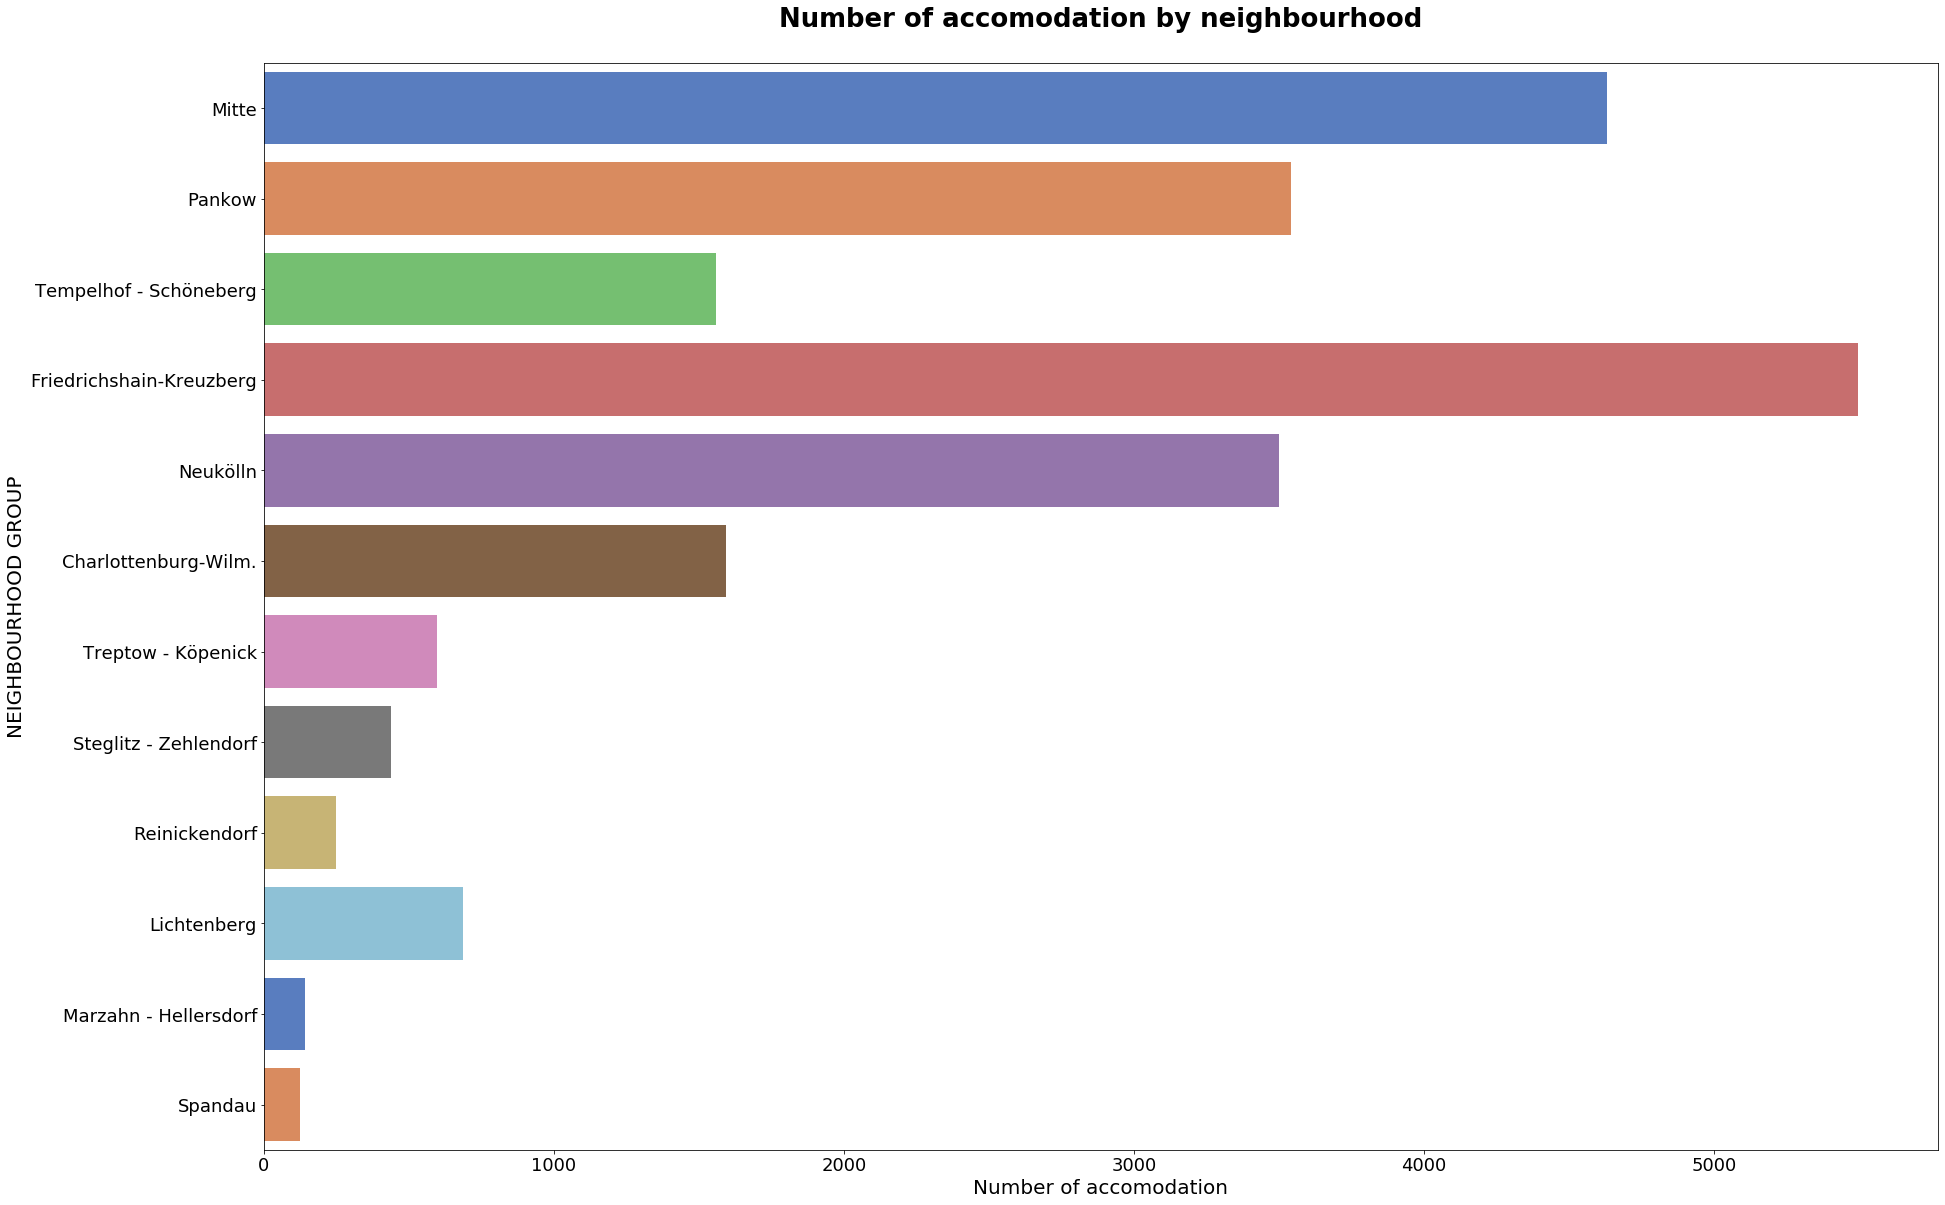

In [39]:
plt.figure(figsize=(30,20))
ax = sns.countplot(y=df["neighbourhood_group_cleansed"], palette="muted") 
ax.set_xlabel("Number of accomodation",fontsize=20)
ax.set_ylabel("NEIGHBOURHOOD GROUP",fontsize=20)
ax.tick_params(labelsize=18)
plt.title('Number of accomodation by neighbourhood\n', fontsize=26, fontweight='bold')
plt.show()

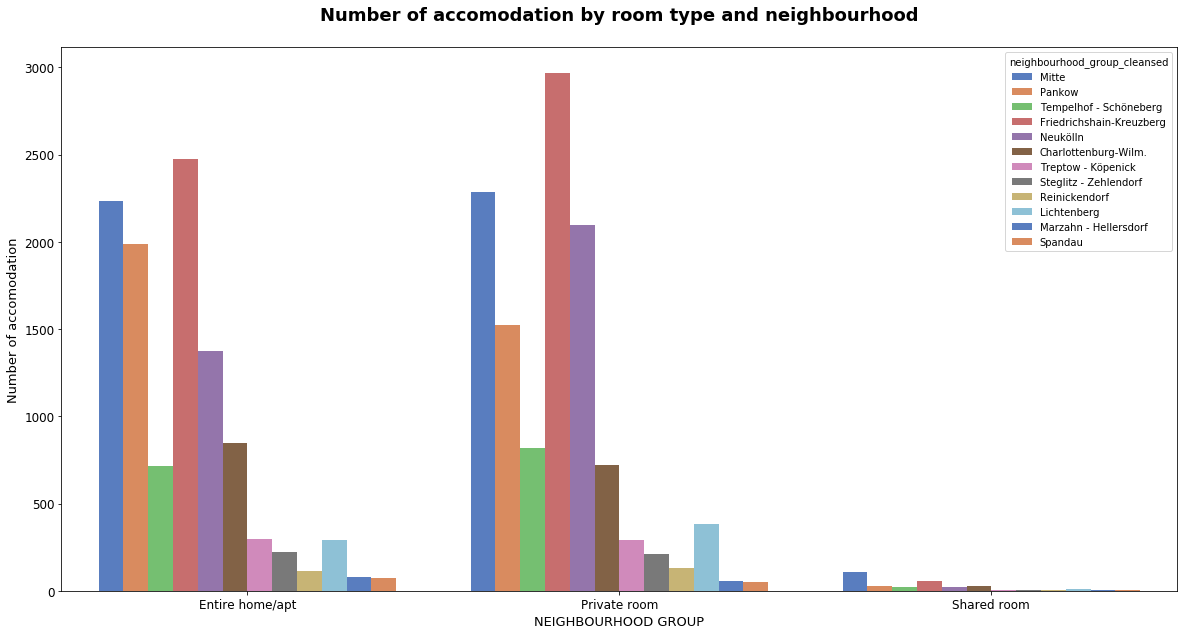

In [40]:
plt.figure(figsize=(20,10))
ax = sns.countplot(df['room_type'],hue=df['neighbourhood_group_cleansed'], palette='muted')
ax.set_xlabel("NEIGHBOURHOOD GROUP",fontsize=13)
ax.set_ylabel("Number of accomodation",fontsize=13)
ax.tick_params(labelsize=12)
plt.title('Number of accomodation by room type and neighbourhood\n', fontsize=18, fontweight='bold')
plt.show()

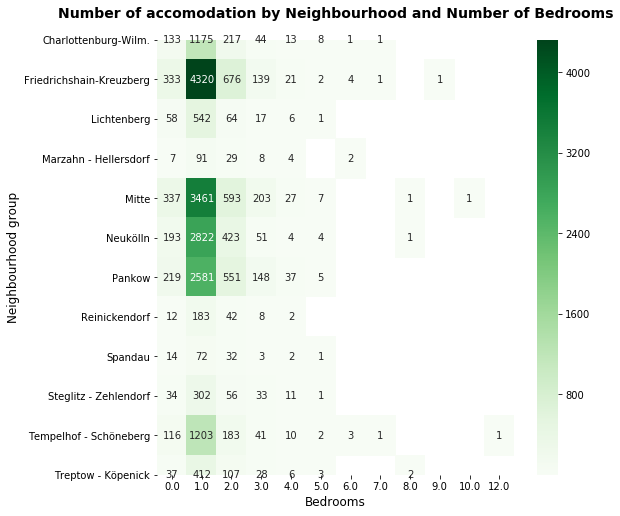

In [41]:
plt.figure(figsize=(8,8))
sns.heatmap(df_cols.groupby(['neighbourhood_group_cleansed', 'bedrooms']).count().id.unstack(), cmap='Greens', annot=True, fmt=".0f")

plt.xlabel('Bedrooms', fontsize=12)
plt.ylabel('Neighbourhood group', fontsize=12)
plt.title('Number of accomodation by Neighbourhood and Number of Bedrooms\n', fontsize=14, fontweight='bold');

id    neighbourhood_cleansed neighbourhood_group_cleansed  \
0          2015           Brunnenstr. Süd                        Mitte   
1          2695  Prenzlauer Berg Nordwest                       Pankow   
2          3176   Prenzlauer Berg Südwest                       Pankow   
3          3309           Schöneberg-Nord       Tempelhof - Schöneberg   
4          7071            Helmholtzplatz                       Pankow   
...         ...                       ...                          ...   
22547  29856708           Brunnenstr. Süd                        Mitte   
22548  29857108           Schöneberg-Nord       Tempelhof - Schöneberg   
22549  29864272   Prenzlauer Berg Südwest                       Pankow   
22550  29866805            Alexanderplatz                        Mitte   
22551  29867352         Schillerpromenade                     Neukölln   

        latitude  longitude   property_type        room_type  accommodates  \
0      52.534537  13.402557      Guesthouse  Entire home/apt             3   
1      52.548513  13.404553       Apartment     Private room             2   
2      52.534996  13.417579       Apartment  Entire home/apt             4   
3      52.498855  13.349065       Apartment     Private room             2   
4      52.543157  13.415091       Apartment     Private room             2   
...          ...        ...             ...              ...           ...   
22547  52.533865  13.400731       Apartment  Entire home/apt             2   
22548  52.496211  13.341738       Apartment      Shared room             6   
22549  52.531800  13.411999            Loft  Entire home/apt             2   
22550  52.520802  13.378688  Boutique hotel     Private room             2   
22551  52.473762  13.424447       Apartment     Private room             2   

       bathrooms  bedrooms  ...  \
0            1.0       1.0  ...   
1            1.0       1.0  ...   
2            1.0       1.0  ...   
3            1.0       1.0  ...   
4            1.0       1.0  ...   
...          ...       ...  ...   
22547        1.0       1.0  ...   
22548        1.0       1.0  ...   
22549        1.0       0.0  ...   
22550        1.0       1.0  ...   
22551        1.0       1.0  ...   

                                               amenities price  \
0      {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...  60.0   
1      {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...  17.0   
2      {Internet,Wifi,Kitchen,"Buzzer/wireless interc...  90.0   
3      {Internet,Wifi,"Pets allowed","Pets live on th...  26.0   
4      {Wifi,Heating,"Family/kid friendly",Essentials...  42.0   
...                                                  ...   ...   
22547  {Wifi,"Smoking allowed",Heating,Essentials,Sha...  60.0   
22548  {TV,Wifi,Kitchen,"Free parking on premises","F...  20.0   
22549  {Wifi,Kitchen,Heating,Washer,"Fire extinguishe...  85.0   
22550  {Wifi,"Paid parking off premises",Doorman,Elev...  99.0   
22551  {Wifi,"Air conditioning",Kitchen,Breakfast,Hea...  45.0   

      security_deposit  cleaning_fee  guests_included  extra_people  \
0                200.0          30.0                1          28.0   
1                  0.0           0.0                1           0.0   
2                200.0          50.0                2          20.0   
3                250.0          30.0                1          18.0   
4                  0.0           0.0                1          24.0   
...                ...           ...              ...           ...   
22547              0.0           0.0                1           0.0   
22548              0.0           0.0                1          10.0   
22549              0.0           0.0                1           0.0   
22550              0.0           0.0                1           0.0   
22551              0.0           0.0                1           0.0   

       minimum_nights  maximum_nights  instant_bookable  \
0                   4            1125                 0   
1 

In [42]:
price_avg=df_cols.price.mean()
print('Prezzo medio per notte: {}'.format(price_avg))

Prezzo medio per notte: 67.14594235033259


In [43]:
df_cols.groupby(['neighbourhood_group_cleansed','room_type']).agg(
    avg_price_room=pd.NamedAgg(column='price', aggfunc='mean'),
    avg_price_cleaning=pd.NamedAgg(column='cleaning_fee', aggfunc='mean'),
    avg_price_deposit=pd.NamedAgg(column='security_deposit', aggfunc='mean'),
    avg_price_extra_people=pd.NamedAgg(column='extra_people', aggfunc='mean'))

avg_price_room  \
neighbourhood_group_cleansed room_type                         
Charlottenburg-Wilm.         Entire home/apt      104.386792   
                             Private room         128.621697   
                             Shared room           36.800000   
Friedrichshain-Kreuzberg     Entire home/apt       80.951111   
                             Private room          44.445568   
                             Shared room           39.127273   
Lichtenberg                  Entire home/apt       69.211604   
                             Private room          47.007833   
                             Shared room           26.916667   
Marzahn - Hellersdorf        Entire home/apt       74.862500   
                             Private room          33.428571   
                             Shared room           21.200000   
Mitte                        Entire home/apt       99.936494   
                             Private room          41.984259   
                             Shared room           30.299065   
Neukölln                     Entire home/apt       64.251636   
                             Private room          35.179133   
                             Shared room           30.375000   
Pankow                       Entire home/apt       80.499497   
                             Private room          48.504924   
                             Shared room          208.466667   
Reinickendorf                Entire home/apt       62.121739   
                             Private room          35.539062   
                             Shared room           57.000000   
Spandau                      Entire home/apt       76.125000   
                             Private room          33.166667   
                             Shared room           37.000000   
Steglitz - Zehlendorf        Entire home/apt       76.004464   
                             Private room          35.767773   
                             Shared room           21.500000   
Tempelhof - Schöneberg       Entire home/apt       79.023710   
                             Private room         113.495726   
                             Shared room           43.333333   
Treptow - Köpenick           Entire home/apt       68.305369   
                             Private room          36.300341   
                             Shared room           19.500000   

                                              avg_price_cleaning  \
neighbourhood_group_cleansed room_type                             
Charlottenburg-Wilm.         Entire home/apt           34.908019   
                             Private room               9.456189   
                             Shared room               10.000000   
Friedrichshain-Kreuzberg     Entire home/apt           26.196364   
                             Private room               9.579710   
                             Shared room                7.254545   
Lichtenberg                  Entire home/apt           21.529010   
                             Private room               7.618799   
                             Shared room                5.833333   
Marzahn - Hellersdorf        Entire home/apt           22.350000   
                             Private room               8.232143   
                             Shared room               14.000000   
Mitte                        Entire home/apt           32.730322   
                             Private room               9.127678   
                             Shared room                3.700935   
Neukölln                     Entire home/apt           19.171636   
                             Private room               8.688423   
                             Shared room                4.916667   
Pankow                       Entire home/apt           29.154427   
                             Private room              10.996717   
                             Shared room                9.333333   
Reinickendorf                Entire home/apt     

In [44]:
fig = px.scatter_mapbox(df_cols[df_cols.price<100], lat="latitude", lon="longitude", color="price", size="bedrooms",
                  color_continuous_scale=px.colors.sequential.RdPu, size_max=15, zoom=11)
#fig.update_layout(title="Distribuzione degli alloggi con indicazione di prezzo e numero di camere\n")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Machine Learning

Ricordiamoci il nostro obiettivo: vogliamo predire il prezzo di un appartamento in modo che sia in linea con la fetta di mercato a cui appartiene.
Andiamo ad analizzare più nel dettaglio le variabili e capire la distribuzione del prezzo.

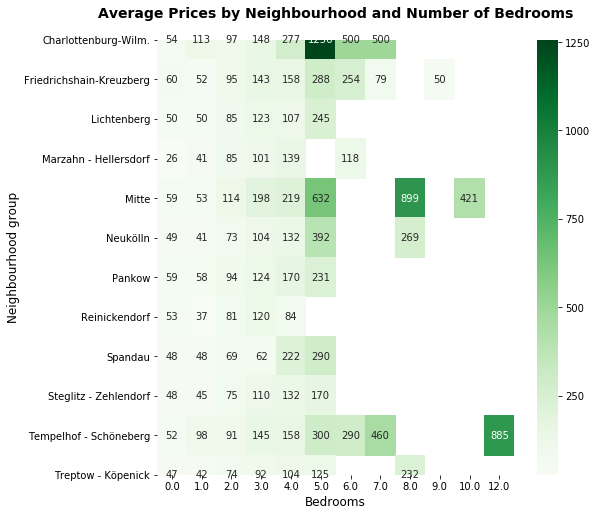

In [45]:
plt.figure(figsize=(8,8))
sns.heatmap(df_cols.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.mean().unstack(), cmap='Greens', annot=True, fmt=".0f")

plt.xlabel('Bedrooms', fontsize=12)
plt.ylabel('Neighbourhood group', fontsize=12)
plt.title('Average Prices by Neighbourhood and Number of Bedrooms\n', fontsize=14, fontweight='bold');

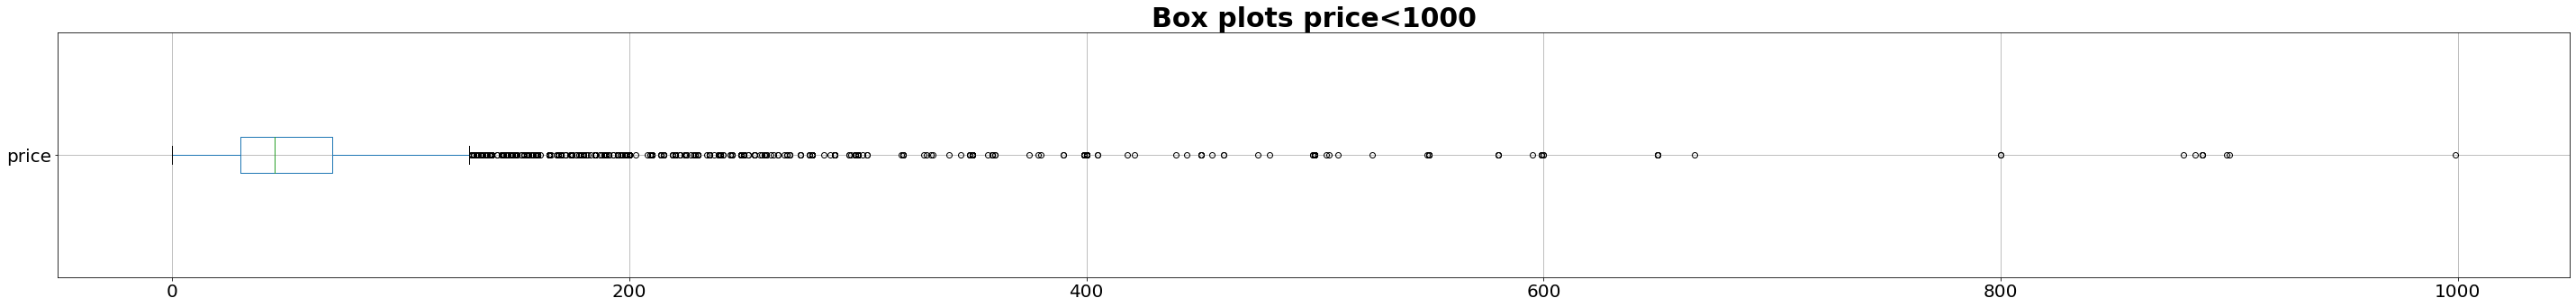

In [46]:
fig = plt.figure(figsize=(50,5))
ax = fig.gca()   
df_cols[df_cols.price<1000].boxplot(column=['price'], ax=ax, vert=False)
fig.suptitle('')
ax.set_title('Box plots price<1000', fontsize=30, fontweight='bold')
ax.tick_params(labelsize=20)
plt.show()

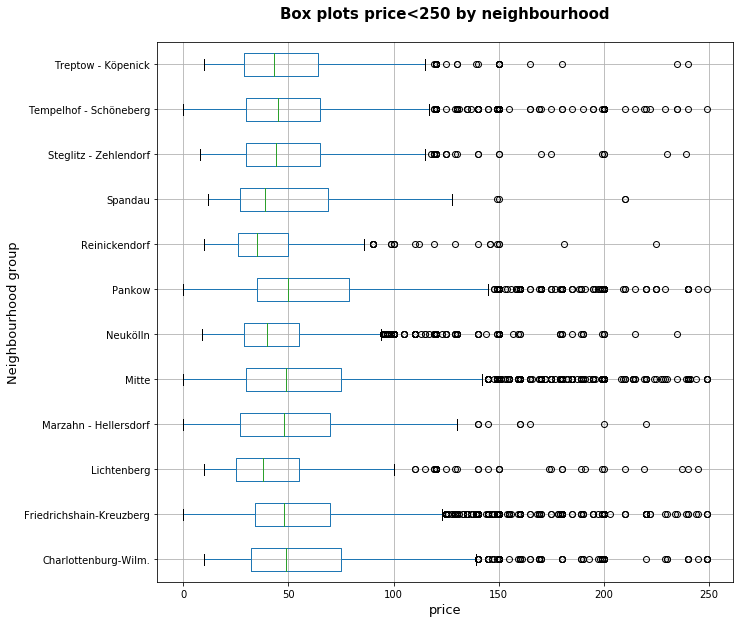

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()   
df_cols[df_cols.price<250].boxplot(column=['price'], by='neighbourhood_group_cleansed', ax=ax, vert=False)
fig.suptitle('')
ax.set_title('Box plots price<250 by neighbourhood\n', fontsize=15, fontweight='bold')
ax.set_xlabel('price',fontsize=13)
ax.set_ylabel('Neighbourhood group',fontsize=13)
plt.show()

In [86]:
tot = df_cols.shape[0]
n_100 = df_cols[df_cols.price<100].id.count()
print (f'Ci sono {n_100} alloggi con prezzo minore di 100$. Sono {round(n_100/tot*100,2)} % del totale')

n_100_1000 = df_cols[(df_cols.price>99) & (df_cols.price<1000)].id.count()
print (f'Ci sono {n_100_1000} alloggi con prezzo minore di 100$. Sono {round(n_100_1000/tot*100,2)} % del totale')

n_1000 = df_cols[(df_cols.price>999)].id.count()
print (f'Ci sono {n_1000} alloggi con prezzo minore di 100$. Sono {round(n_1000/tot*100,2)} % del totale')

Ci sono 20014 alloggi con prezzo minore di 100$. Sono 88.75 % del totale
Ci sono 2495 alloggi con prezzo minore di 100$. Sono 11.06 % del totale
Ci sono 41 alloggi con prezzo minore di 100$. Sono 0.18 % del totale


Per quanto riguarda il prezzo ci sono molti outlier. Dalle rappresentazioni precedenti possiamo dedurre che la maggior parte dei valori si concentra intorno ai 50 dollari. Inoltre, nonostante il prezzo massimo sia 9000 dollari. gli alloggi che costano più di 1000 dollari sono molto pochi.

Rappresentando la distribuzione del prezzo, possiamo utilizzare una trasformazione logaritmica. Questo ci aiuta poichè in questo modo è possibile trattare meglio gli outliers, avvicinandoci ad una normale. Infatti, in problemi di regressione è possibile in cui la distribuzione presenta delle code anomale, l'algoritmo potrebbe non comportarsi nella maniera ottimale.

Text(0.5, 0, 'log(1+price)')

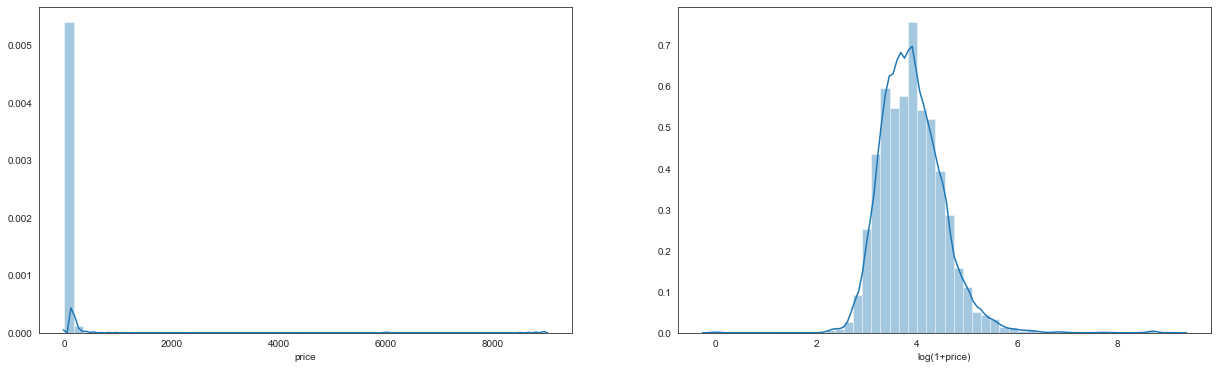

In [195]:
fig, axes = plt.subplots(1,2, figsize=(21,6))

sns.distplot(df_cols['price'], ax=axes[0])
sns.distplot(np.log1p(df_cols['price']), ax=axes[1])

axes[1].set_xlabel('log(1+price)')


In [87]:
df_cols['price'] = np.log1p(df_cols['price'])

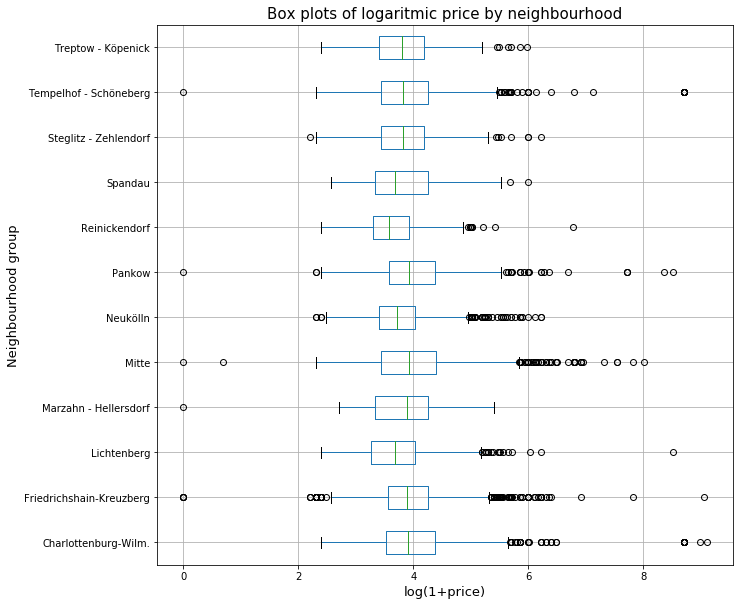

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
df_cols.boxplot(column=['price'], by='neighbourhood_group_cleansed', ax=ax, vert=False)
fig.suptitle('')
ax.set_title('Box plots of logaritmic price by neighbourhood', fontsize=15)
ax.set_xlabel('log(1+price)',fontsize=13) 
ax.set_ylabel('Neighbourhood group',fontsize=13)
plt.show()

In [89]:
#Relazione tra prezzo, numero di camere e tipo di camera

Ora è necessario valutare la correlazione tra variabili, in modo da definire meglio le feature da selezionare

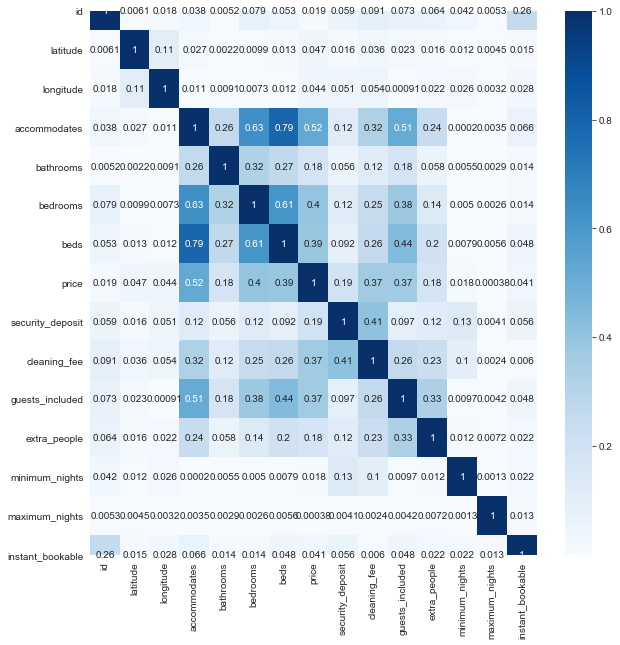

In [99]:
plt.figure(figsize=(10,10))
cor = abs(df_cols.corr())
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

Come si può notare dalla matrice di correlazione, ci sono alcune variabili che sono fortemente correlate.
Le correlazioni più alte si hanno tra il numero di persone ospitate, il numero di letti e il numero di camere, considerazione che potevamo aspettarci.
La correlazione più alta si ha tra il numero di letti (*beds*) e il numero di ospiti (*accommodates*). A seguire, il numero di camere (*bedrooms*) è correlato con il numero di ospiti (*accommodates*) e il numero di letti (*beds*).
Infine, si hanno livelli di correlazione abbastanza alti anche tra ospiti aggiuntivi (*guest_included*) e il numero di ospiti, di camere e di letti.

Le variabili che invece non risultano correlate a nessuna altra variabile sono le coordinate spaziali (*latitude*, *longitude*) e il numero massimo e minimo di notti in cui si può soggiornare (*minimum_nights*, *maximum_nights*)


Visto l'elevato livello di correlazione, si può ulteriormente raffinare il numero di colonne che andremo ad utilizzare per il nostro scopo di predire il prezzo di un alloggio con determinate caratteristiche.
Posso andare ad eliminare le variabili *accommodates*, *beds* e *guest_included*.

In [100]:
df_cols = df_cols.drop(['accommodates', 'beds', 'guests_included'], axis=1)
df_cols.head()

id    neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
0  2015           Brunnenstr. Süd                        Mitte  52.534537   
1  2695  Prenzlauer Berg Nordwest                       Pankow  52.548513   
2  3176   Prenzlauer Berg Südwest                       Pankow  52.534996   
3  3309           Schöneberg-Nord       Tempelhof - Schöneberg  52.498855   
4  7071            Helmholtzplatz                       Pankow  52.543157   

   longitude property_type        room_type  bathrooms  bedrooms  \
0  13.402557    Guesthouse  Entire home/apt        1.0       1.0   
1  13.404553     Apartment     Private room        1.0       1.0   
2  13.417579     Apartment  Entire home/apt        1.0       1.0   
3  13.349065     Apartment     Private room        1.0       1.0   
4  13.415091     Apartment     Private room        1.0       1.0   

        bed_type                                          amenities     price  \
0       Real Bed  {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...  4.110874   
1       Real Bed  {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...  2.890372   
2       Real Bed  {Internet,Wifi,Kitchen,"Buzzer/wireless interc...  4.510860   
3  Pull-out Sofa  {Internet,Wifi,"Pets allowed","Pets live on th...  3.295837   
4       Real Bed  {Wifi,Heating,"Family/kid friendly",Essentials...  3.761200   

   security_deposit  cleaning_fee  extra_people  minimum_nights  \
0             200.0          30.0          28.0               4   
1               0.0           0.0           0.0               2   
2             200.0          50.0          20.0              62   
3             250.0          30.0          18.0               5   
4               0.0           0.0          24.0               2   

   maximum_nights  instant_bookable          cancellation_policy  
0            1125                 0  strict_14_with_grace_period  
1              40                 0                     flexible  
2            1125                 1  strict_14_with_grace_period  
3             360                 0  strict_14_with_grace_period  
4              10                 0                     moderate

Dal dataset che è stato fino ad ora costruito, eliminiamo anche la colonna *amenities*, in quanto sarebbe necessaria un'analisi più approfondita per estrarre i servizi disponibili in ogni alloggio.

In [101]:
df_cols = df_cols.drop(['amenities'], axis=1)
df_cols.head()

id    neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
0  2015           Brunnenstr. Süd                        Mitte  52.534537   
1  2695  Prenzlauer Berg Nordwest                       Pankow  52.548513   
2  3176   Prenzlauer Berg Südwest                       Pankow  52.534996   
3  3309           Schöneberg-Nord       Tempelhof - Schöneberg  52.498855   
4  7071            Helmholtzplatz                       Pankow  52.543157   

   longitude property_type        room_type  bathrooms  bedrooms  \
0  13.402557    Guesthouse  Entire home/apt        1.0       1.0   
1  13.404553     Apartment     Private room        1.0       1.0   
2  13.417579     Apartment  Entire home/apt        1.0       1.0   
3  13.349065     Apartment     Private room        1.0       1.0   
4  13.415091     Apartment     Private room        1.0       1.0   

        bed_type     price  security_deposit  cleaning_fee  extra_people  \
0       Real Bed  4.110874             200.0          30.0          28.0   
1       Real Bed  2.890372               0.0           0.0           0.0   
2       Real Bed  4.510860             200.0          50.0          20.0   
3  Pull-out Sofa  3.295837             250.0          30.0          18.0   
4       Real Bed  3.761200               0.0           0.0          24.0   

   minimum_nights  maximum_nights  instant_bookable  \
0               4            1125                 0   
1               2              40                 0   
2              62            1125                 1   
3               5             360                 0   
4               2              10                 0   

           cancellation_policy  
0  strict_14_with_grace_period  
1                     flexible  
2  strict_14_with_grace_period  
3  strict_14_with_grace_period  
4                     moderate

Visto che abbiamo la latitudine e la longitudine, possiamo eliminare le colonne *neighbourhood_cleansed* e *neighbourhood_group_cleansed* che forniscono anche loro indicazioni sulla posizione

In [102]:
df_cols = df_cols.drop(['neighbourhood_cleansed','neighbourhood_group_cleansed'], axis=1)
df_cols.head()

id   latitude  longitude property_type        room_type  bathrooms  \
0  2015  52.534537  13.402557    Guesthouse  Entire home/apt        1.0   
1  2695  52.548513  13.404553     Apartment     Private room        1.0   
2  3176  52.534996  13.417579     Apartment  Entire home/apt        1.0   
3  3309  52.498855  13.349065     Apartment     Private room        1.0   
4  7071  52.543157  13.415091     Apartment     Private room        1.0   

   bedrooms       bed_type     price  security_deposit  cleaning_fee  \
0       1.0       Real Bed  4.110874             200.0          30.0   
1       1.0       Real Bed  2.890372               0.0           0.0   
2       1.0       Real Bed  4.510860             200.0          50.0   
3       1.0  Pull-out Sofa  3.295837             250.0          30.0   
4       1.0       Real Bed  3.761200               0.0           0.0   

   extra_people  minimum_nights  maximum_nights  instant_bookable  \
0          28.0               4            1125                 0   
1           0.0               2              40                 0   
2          20.0              62            1125                 1   
3          18.0               5             360                 0   
4          24.0               2              10                 0   

           cancellation_policy  
0  strict_14_with_grace_period  
1                     flexible  
2  strict_14_with_grace_period  
3  strict_14_with_grace_period  
4                     moderate

In [103]:
def calc_missing(df_ml):
    total = df_ml.isnull().sum().sort_values(ascending=False)
    percent = (df_ml.isnull().sum())/df_ml.isnull().count().sort_values(ascending=False)

    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False
                                ).sort_values('Total', ascending=False)

    return missing_data
calc_missing(df_cols)

Total  Percent
cancellation_policy      0      0.0
instant_bookable         0      0.0
maximum_nights           0      0.0
minimum_nights           0      0.0
extra_people             0      0.0
cleaning_fee             0      0.0
security_deposit         0      0.0
price                    0      0.0
bed_type                 0      0.0
bedrooms                 0      0.0
bathrooms                0      0.0
room_type                0      0.0
property_type            0      0.0
longitude                0      0.0
latitude                 0      0.0
id                       0      0.0

Visto che alcuni modelli non trattano le features categoriche, è necessario trasformarle in forma numerica. Per fare ciò devono essere considerate come variabili dummy.

In [104]:
cat_features = df_cols.select_dtypes(include=['object'])
cat_features = pd.get_dummies(cat_features)
cat_features.head()

property_type_Aparthotel  property_type_Apartment  property_type_Barn  \
0                         0                        0                   0   
1                         0                        1                   0   
2                         0                        1                   0   
3                         0                        1                   0   
4                         0                        1                   0   

   property_type_Bed and breakfast  property_type_Boat  \
0                                0                   0   
1                                0                   0   
2                                0                   0   
3                                0                   0   
4                                0                   0   

   property_type_Boutique hotel  property_type_Bungalow  property_type_Cabin  \
0                             0                       0                    0   
1                             0                       0                    0   
2                             0                       0                    0   
3                             0                       0                    0   
4                             0                       0                    0   

   property_type_Camper/RV  property_type_Casa particular (Cuba)  ...  \
0                        0                                     0  ...   
1                        0                                     0  ...   
2                        0                                     0  ...   
3                        0                                     0  ...   
4                        0                                     0  ...   

   bed_type_Airbed  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  \
0                0               0               0                       0   
1                0               0               0                       0   
2                0               0               0                       0   
3                0               0               0                       1   
4                0               0               0                       0   

   bed_type_Real Bed  cancellation_policy_flexible  \
0                  1                             0   
1                  1                             1   
2                  1                             0   
3                  0                             0   
4                  1                             0   

   cancellation_policy_moderate  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             1   

   cancellation_policy_strict_14_with_grace_period  \
0                                                1   
1                                                0   
2                                                1   
3                                                1   
4                                                0   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  
0                                    0                                    0  
1                                    0                                    0  
2                                    0                                    0  
3                                    0                                    0  
4                                    0                                    0  

[5 rows x 46 columns]

Possimo ora costruire il dataset che andrà dato al modello.

In [105]:
num_features = pd.DataFrame()
num_features = df_cols.select_dtypes(exclude='object')

In [106]:
num_features.head()

id   latitude  longitude  bathrooms  bedrooms     price  \
0  2015  52.534537  13.402557        1.0       1.0  4.110874   
1  2695  52.548513  13.404553        1.0       1.0  2.890372   
2  3176  52.534996  13.417579        1.0       1.0  4.510860   
3  3309  52.498855  13.349065        1.0       1.0  3.295837   
4  7071  52.543157  13.415091        1.0       1.0  3.761200   

   security_deposit  cleaning_fee  extra_people  minimum_nights  \
0             200.0          30.0          28.0               4   
1               0.0           0.0           0.0               2   
2             200.0          50.0          20.0              62   
3             250.0          30.0          18.0               5   
4               0.0           0.0          24.0               2   

   maximum_nights  instant_bookable  
0            1125                 0  
1              40                 0  
2            1125                 1  
3             360                 0  
4              10                 0

In [107]:
y = num_features['price']
num_features = num_features.drop(['price'], axis=1)

features = pd.DataFrame()
features = pd.concat([num_features, cat_features], axis=1)
features.set_index(['id'])

latitude  longitude  bathrooms  bedrooms  security_deposit  \
id                                                                      
2015      52.534537  13.402557        1.0       1.0             200.0   
2695      52.548513  13.404553        1.0       1.0               0.0   
3176      52.534996  13.417579        1.0       1.0             200.0   
3309      52.498855  13.349065        1.0       1.0             250.0   
7071      52.543157  13.415091        1.0       1.0               0.0   
...             ...        ...        ...       ...               ...   
29856708  52.533865  13.400731        1.0       1.0               0.0   
29857108  52.496211  13.341738        1.0       1.0               0.0   
29864272  52.531800  13.411999        1.0       0.0               0.0   
29866805  52.520802  13.378688        1.0       1.0               0.0   
29867352  52.473762  13.424447        1.0       1.0               0.0   

          cleaning_fee  extra_people  minimum_nights  maximum_nights  \
id                                                                     
2015              30.0          28.0               4            1125   
2695               0.0           0.0               2              40   
3176              50.0          20.0              62            1125   
3309              30.0          18.0               5             360   
7071               0.0          24.0               2              10   
...                ...           ...             ...             ...   
29856708           0.0           0.0               2            1125   
29857108           0.0          10.0               1              14   
29864272           0.0           0.0               3              30   
29866805           0.0           0.0               1              10   
29867352           0.0           0.0               5              14   

          instant_bookable  ...  bed_type_Airbed  bed_type_Couch  \
id                          ...                                    
2015                     0  ...                0               0   
2695                     0  ...                0               0   
3176                     1  ...                0               0   
3309                     0  ...                0               0   
7071                     0  ...                0               0   
...                    ...  ...              ...             ...   
29856708                 0  ...                0               0   
29857108                 1  ...                0               0   
29864272                 0  ...                0               0   
29866805                 0  ...                0               0   
29867352                 0  ...                0               0   

          bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
id                                                                    
2015                   0                       0                  1   
2695                   0                       0                  1   
3176                   0                       0                  1   
3309                   0                       1                  0   
7071                   0                       0                  1   
...                  ...                     ...                ...   
29856708               0                       0                  1   
29857108               0                       0                  1   
29864272               0                       0                  1   
29866805               0                       0                  1   
29867352               0                       0                  1   

          cancellation_policy_flexible  cancellation_policy_moderate  \
id                                                                     
2015                                 0                             0   
2695                                 1                             0   
3176                       

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=RANDOM_SEED)

In [109]:
print(f'X_train {X_train.shape}')
print(f'X_test {X_test.shape}')
print(f'y_train {y_train.shape}')
print(f'y_test {y_test.shape}')

X_train (18040, 57)
X_test (4510, 57)
y_train (18040,)
y_test (4510,)


In [110]:
print(f'X_train null: {X_train.isnull().sum().sum()}')
print(f'X_test null: {X_test.isnull().sum().sum()}')
print(f'y_train null: {y_train.isnull().sum().sum()}')
print(f'y_test null: {y_test.isnull().sum().sum()}')

X_train null: 0
X_test null: 0
y_train null: 0
y_test null: 0


Nel modello sono presenti delle features che hanno un dominio su scale diverse e che potrebbero contenere degli outlier.
A causa di ciò, le performance di molti algoritmi di machine learnig vengono negativamente impattate e inoltre la convergenza viene rallentata o addirittura non raggiunta.
Scegliamo di usare un Robust Scaler, visto che  le statistiche di centratura e ridimensionamento di questo scaler si basano su percentili e non sono influenzate da un numero limitato di outliers.

In [111]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [113]:
#giusto fit_intercept false?
lm = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
model = lm.fit(X_train, y_train)
#LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
prediction = lm.predict(X_test)
score = model.score(X_test, y_test)
print('Linear Regression R2: ' + str(score))
prediction

Linear Regression R2: 0.40490666358850047


array([3.66228881, 3.55227647, 3.61790568, ..., 4.5188602 , 3.28653194,
       5.3903564 ])

In [114]:
scores = cross_val_score(model, features, y, cv=K_FOLDS)
print ('Cross-validated scores:', scores)

Cross-validated scores: [0.38346711 0.4215101  0.47249318 0.40249961 0.27198508]


In [115]:
# Make cross validated predictions
predictions = cross_val_predict(model, features, y, cv=K_FOLDS)
prediction

array([3.66228881, 3.55227647, 3.61790568, ..., 4.5188602 , 3.28653194,
       5.3903564 ])

In [116]:
accuracy = metrics.r2_score(y, predictions)
print ('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.39124975380345883


L'accuratezza è diminuita utilizzando la k-fold cross validation. Ciò potrebbe dipendere da come è stato suddiviso il dataset nel test di regressione lineare iniziale.